# Anomaly Detection - Isolation Forests

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
from sklearn.ensemble import IsolationForest

import seaborn
from scipy.spatial.distance import pdist, squareform

import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [2]:
cyclists_dataset = pd.read_csv('../data/cyclists_dataset_fe.csv', dtype={'cyclist_team': str})
cyclists_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6095 entries, 0 to 6094
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cyclist_url      6095 non-null   object 
 1   mean_cyclist_cp  5011 non-null   float64
 2   mean_delta       6095 non-null   float64
 3   mean_position    6095 non-null   float64
 4   birth_year       6095 non-null   int64  
 5   weight           3134 non-null   float64
 6   height           3134 non-null   float64
 7   nationality      6095 non-null   object 
 8   cyclist_name     6095 non-null   object 
 9   cyclist_bmi      3134 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 476.3+ KB


In [3]:
races_dataset = pd.read_csv('../data/races_dataset_fe.csv')
races_dataset['date'] = pd.to_datetime(races_dataset['date'], format='%Y-%m-%d')
races_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5281 entries, 0 to 5280
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   race_url              5281 non-null   object        
 1   race_name             5281 non-null   object        
 2   points                5281 non-null   float64       
 3   uci_points            2780 non-null   float64       
 4   length                5281 non-null   float64       
 5   climb_total           3326 non-null   float64       
 6   profile               3326 non-null   float64       
 7   startlist_quality     5281 non-null   int64         
 8   date                  5281 non-null   datetime64[ns]
 9   mostly_tarmac         5281 non-null   bool          
 10  race_year             5281 non-null   int64         
 11  race_stage            5281 non-null   object        
 12  race_season           5281 non-null   object        
 13  climb_percentage  

In [4]:
complete_dataset = pd.read_csv('../data/complete_dataset_fe.csv', dtype={'cyclist_team': str})
complete_dataset['date'] = pd.to_datetime(complete_dataset['date'], format='%Y-%m-%d')
complete_dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589739 entries, 0 to 589738
Data columns (total 38 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   cyclist_url                  589739 non-null  object        
 1   cyclist_name                 589739 non-null  object        
 2   birth_year                   589739 non-null  int64         
 3   weight                       480007 non-null  float64       
 4   height                       480007 non-null  float64       
 5   nationality                  589739 non-null  object        
 6   race_url                     589739 non-null  object        
 7   race_name                    589739 non-null  object        
 8   points                       589739 non-null  float64       
 9   uci_points                   422184 non-null  float64       
 10  length                       589739 non-null  float64       
 11  climb_total               

## Anomaly Detection - Cyclists Dataset

<class 'pandas.core.frame.DataFrame'>
Index: 3060 entries, 0 to 6093
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_cyclist_cp  3060 non-null   float64
 1   mean_delta       3060 non-null   float64
 2   mean_position    3060 non-null   float64
 3   birth_year       3060 non-null   int64  
 4   weight           3060 non-null   float64
 5   height           3060 non-null   float64
 6   cyclist_bmi      3060 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 191.2 KB


<Axes: >

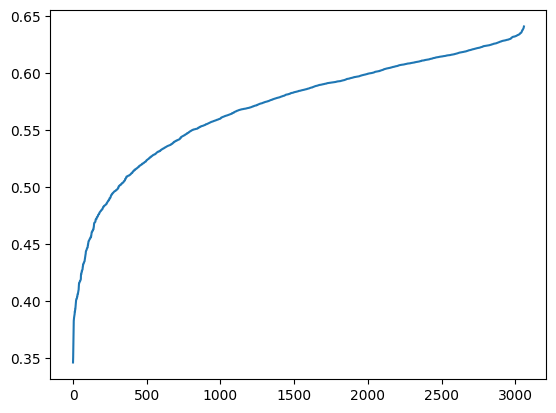

In [5]:
# Filter the dataset to keep only numeric and non-NaN rows
numeric_dataset = cyclists_dataset.select_dtypes(include=['number'])
numeric_dataset = numeric_dataset.dropna()
numeric_dataset.info()

max_features = numeric_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(numeric_dataset)

# Calculate outlier degrees and scores
outlier_degrees = algorithm.decision_function(numeric_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(numeric_dataset) + 1) / 2

# Combine with original dataset
dataset_with_outlier_scores = cyclists_dataset.copy()

# Initialize the new columns with NaN to match the original dataset's length
dataset_with_outlier_scores["isolation_forest_degree"] = float("nan")
dataset_with_outlier_scores["isolation_forest_scores"] = float("nan")

# Assign outlier scores only to the rows used in numeric_dataset
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_degree"] = outlier_degrees
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_scores"] = outlier_scores

# Plot sorted outlier degrees, with x matching its length
sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(len(sorted_outlier_degrees)),  # x-axis matches the length of sorted_outlier_degrees
    y=sorted_outlier_degrees
)

The outlier_degrees array provides a measure of how far each sample is from the decision boundary (the value is normalized):
- Close to 1: More likely to be an inlier.
- Close to 0: More likely to be an outlier.


The outlier_scores array represents a "binarized likelihood" of each data point being an outlier (scores values are 0 or 1):
- 1: More likely to be an outlier.
- 0: More likely to be an inlier.

In [6]:
degree_threshold = 0.5

# Combine thresholds for outlier detection
dataset_with_outlier_scores["is_outlier"] = (
    (dataset_with_outlier_scores["isolation_forest_scores"] == 1) &
    (dataset_with_outlier_scores["isolation_forest_degree"] < degree_threshold)
)

len(dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1])

309

In [7]:
anomalies = dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1]

anomalies.describe()

,mean_cyclist_cp,mean_delta,mean_position,birth_year,weight,height,cyclist_bmi,isolation_forest_degree,isolation_forest_scores
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.0
mean,0.011654,573.774525,0.561677,1981.012945,67.617799,177.055016,21.491605,0.459256,1.0
std,0.020919,695.631792,0.230922,16.013382,10.627233,9.683643,2.278524,0.034242,0.0
min,0.000002,3.000000,0.044118,1940.000000,48.000000,154.000000,16.412069,0.346428,1.0
25%,0.000556,194.065217,0.377473,1974.000000,59.000000,169.000000,19.605192,0.434781,1.0
50%,0.002429,400.884615,0.539184,1984.000000,67.000000,177.000000,21.380993,0.471485,1.0
75%,0.010358,695.428571,0.739030,1993.000000,75.000000,184.000000,23.200543,0.486353,1.0
max,0.107286,7291.800000,1.000000,2004.000000,94.000000,204.000000,27.770313,0.499539,1.0


In [8]:
# The outliers found are now filtered from the dataset
dataset_with_outlier_scores = dataset_with_outlier_scores[dataset_with_outlier_scores['is_outlier'] != 1]

# Remove specified columns (used just during computation and analysis)
columns_to_remove = ['isolation_forest_scores', 'isolation_forest_degree', 'is_outlier']
final_dataset = dataset_with_outlier_scores.drop(columns=columns_to_remove)

# The dataset is now saved in csv format
final_dataset.to_csv('../data/cyclists_dataset_no_outliers.csv', index=False)

## Anomaly Detection - Races Dataset

<class 'pandas.core.frame.DataFrame'>
Index: 2384 entries, 58 to 4927
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   points                2384 non-null   float64
 1   uci_points            2384 non-null   float64
 2   length                2384 non-null   float64
 3   climb_total           2384 non-null   float64
 4   profile               2384 non-null   float64
 5   startlist_quality     2384 non-null   int64  
 6   race_year             2384 non-null   int64  
 7   climb_percentage      2384 non-null   float64
 8   race_physical_effort  2384 non-null   float64
 9   race_prestige         2384 non-null   float64
 10  num_participants      2384 non-null   int64  
dtypes: float64(8), int64(3)
memory usage: 223.5 KB


<Axes: >

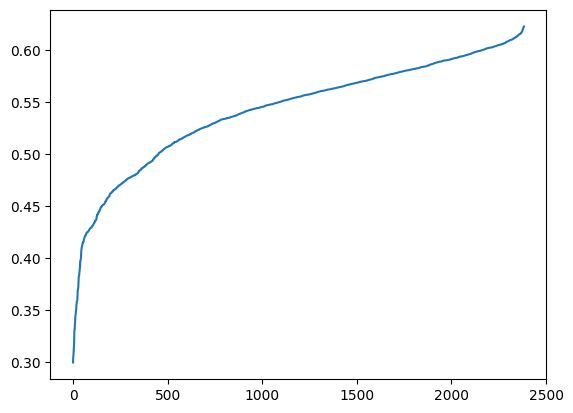

In [9]:
# Filter the dataset to keep only numeric and non-NaN rows
numeric_dataset = races_dataset.select_dtypes(include=['number'])
numeric_dataset = numeric_dataset.dropna()
numeric_dataset.info()

max_features = numeric_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(numeric_dataset)

# Calculate outlier degrees and scores
outlier_degrees = algorithm.decision_function(numeric_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(numeric_dataset) + 1) / 2

# Combine with original dataset
dataset_with_outlier_scores = races_dataset.copy()

# Initialize the new columns with NaN to match the original dataset's length
dataset_with_outlier_scores["isolation_forest_degree"] = float("nan")
dataset_with_outlier_scores["isolation_forest_scores"] = float("nan")

# Assign outlier scores only to the rows used in numeric_dataset
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_degree"] = outlier_degrees
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_scores"] = outlier_scores

# Plot sorted outlier degrees, with x matching its length
sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(len(sorted_outlier_degrees)),  # x-axis matches the length of sorted_outlier_degrees
    y=sorted_outlier_degrees
)

The outlier_degrees array provides a measure of how far each sample is from the decision boundary (the value is normalized):
- Close to 1: More likely to be an inlier.
- Close to 0: More likely to be an outlier.


The outlier_scores array represents a "binarized likelihood" of each data point being an outlier (scores values are 0 or 1):
- 1: More likely to be an outlier.
- 0: More likely to be an inlier.

In [10]:
degree_threshold = 0.5

# Combine thresholds for outlier detection
dataset_with_outlier_scores["is_outlier"] = (
    (dataset_with_outlier_scores["isolation_forest_scores"] == 1) &
    (dataset_with_outlier_scores["isolation_forest_degree"] < degree_threshold)
)

len(dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1])

452

In [11]:
anomalies = dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1]

anomalies.describe()

,points,uci_points,length,climb_total,profile,startlist_quality,date,race_year,climb_percentage,race_physical_effort,race_prestige,num_participants,isolation_forest_degree,isolation_forest_scores
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.0
mean,167.422566,272.971239,181.530951,2.913363,2.915929,1015.918142,2013-06-23 14:58:24.424778752,2013.044248,0.028512,0.219465,0.265449,126.953540,0.454086,1.0
min,20.000000,6.000000,1.900000,0.003000,1.000000,156.000000,2001-03-03 00:00:00,2001.000000,0.000261,0.000003,0.000000,30.000000,0.299489,1.0
25%,80.000000,60.000000,165.075000,1.444500,2.000000,747.750000,2007-04-06 00:00:00,2007.000000,0.008415,0.045765,0.112808,100.000000,0.434043,1.0
50%,125.000000,300.000000,202.550000,2.994000,2.000000,929.000000,2014-04-01 12:00:00,2014.000000,0.016455,0.170920,0.265181,125.000000,0.466434,1.0
75%,275.000000,500.000000,245.000000,4.377000,5.000000,1221.250000,2019-07-19 06:00:00,2019.000000,0.025186,0.338087,0.352412,157.000000,0.481057,1.0
max,350.000000,800.000000,305.000000,6.939000,5.000000,1812.000000,2023-07-29 00:00:00,2023.000000,0.981053,0.910685,0.908128,198.000000,0.499675,1.0
std,94.871512,213.605946,84.052098,1.759200,1.458065,388.585068,NaN,7.022156,0.071705,0.209990,0.170960,36.800476,0.040008,0.0


In [12]:
# The outliers found are now filtered from the dataset
dataset_with_outlier_scores = dataset_with_outlier_scores[dataset_with_outlier_scores['is_outlier'] != 1]

# Remove specified columns (used just during computation and analysis)
columns_to_remove = ['isolation_forest_scores', 'isolation_forest_degree', 'is_outlier']
final_dataset = dataset_with_outlier_scores.drop(columns=columns_to_remove)

# The dataset is now saved in csv format
final_dataset.to_csv('../data/races_dataset_no_outliers.csv', index=False)

## Anomaly Detection - Cyclist + Races Merged Dataset

<class 'pandas.core.frame.DataFrame'>
Index: 348047 entries, 59 to 589737
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   birth_year                   348047 non-null  int64  
 1   weight                       348047 non-null  float64
 2   height                       348047 non-null  float64
 3   points                       348047 non-null  float64
 4   uci_points                   348047 non-null  float64
 5   length                       348047 non-null  float64
 6   climb_total                  348047 non-null  float64
 7   profile                      348047 non-null  float64
 8   startlist_quality            348047 non-null  int64  
 9   position                     348047 non-null  float64
 10  cyclist_age                  348047 non-null  int64  
 11  delta                        348047 non-null  float64
 12  race_year                    348047 non-null  int64  
 13  raw

<Axes: >

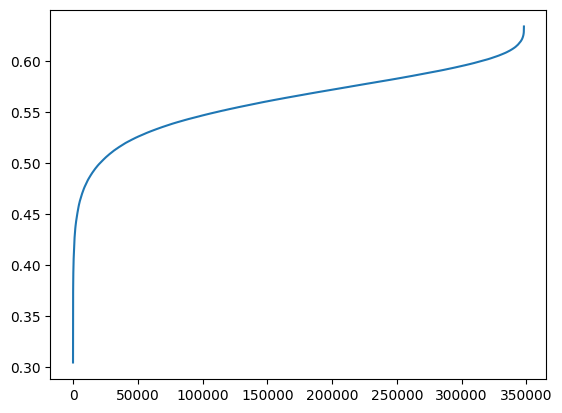

In [13]:
# Filter the dataset to keep only numeric and non-NaN rows
numeric_dataset = complete_dataset.select_dtypes(include=['number'])
numeric_dataset = numeric_dataset.dropna()
numeric_dataset.info()

max_features = numeric_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(numeric_dataset)

# Calculate outlier degrees and scores
outlier_degrees = algorithm.decision_function(numeric_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(numeric_dataset) + 1) / 2

# Combine with original dataset
dataset_with_outlier_scores = complete_dataset.copy()

# Initialize the new columns with NaN to match the original dataset's length
dataset_with_outlier_scores["isolation_forest_degree"] = float("nan")
dataset_with_outlier_scores["isolation_forest_scores"] = float("nan")

# Assign outlier scores only to the rows used in numeric_dataset
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_degree"] = outlier_degrees
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_scores"] = outlier_scores

# Plot sorted outlier degrees, with x matching its length
sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(len(sorted_outlier_degrees)),  # x-axis matches the length of sorted_outlier_degrees
    y=sorted_outlier_degrees
)

The outlier_degrees array provides a measure of how far each sample is from the decision boundary (the value is normalized):
- Close to 1: More likely to be an inlier.
- Close to 0: More likely to be an outlier.


The outlier_scores array represents a "binarized likelihood" of each data point being an outlier (scores values are 0 or 1):
- 1: More likely to be an outlier.
- 0: More likely to be an inlier.

In [14]:
degree_threshold = 0.5

# Combine thresholds for outlier detection
dataset_with_outlier_scores["is_outlier"] = (
    (dataset_with_outlier_scores["isolation_forest_scores"] == 1) &
    (dataset_with_outlier_scores["isolation_forest_degree"] < degree_threshold)
)

len(dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1])

20929

In [15]:
anomalies = dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1]

anomalies.describe()

,birth_year,weight,height,points,uci_points,length,climb_total,profile,startlist_quality,date,...,mean_cyclist_cp,mean_delta,mean_position,previous_mean_position,previous_mean_delta,previous_mean_cp,cyclist_previous_experience,num_participants,isolation_forest_degree,isolation_forest_scores
count,20929.000000,20929.000000,20929.000000,20929.000000,20929.000000,20929.000000,20929.000000,20929.000000,20929.000000,20929,...,20929.000000,20929.000000,20929.000000,20929.000000,20929.000000,20929.000000,20929.000000,20929.000000,20929.000000,20929.0
mean,1985.032634,68.558221,180.363180,178.784940,296.601940,189.871840,2.752136,2.664437,1022.902480,2014-08-09 03:38:35.428353024,...,0.013769,460.357409,0.456531,0.459952,457.242516,0.019013,0.323892,131.783649,0.473465,1.0
min,1963.000000,48.000000,158.000000,20.000000,6.000000,1.150000,0.002000,1.000000,156.000000,2001-03-03 00:00:00,...,0.000009,38.142857,0.086467,0.008065,0.000000,0.000003,0.000185,30.000000,0.304767,1.0
25%,1980.000000,63.000000,175.000000,80.000000,40.000000,161.000000,1.428000,2.000000,798.000000,2009-08-29 00:00:00,...,0.002046,228.212598,0.305742,0.312417,212.345865,0.001821,0.071288,102.000000,0.462513,1.0
50%,1985.000000,68.000000,180.000000,225.000000,400.000000,219.600000,2.779000,2.000000,975.000000,2015-03-22 00:00:00,...,0.004648,420.902507,0.462563,0.457893,387.764706,0.004358,0.235837,134.000000,0.480803,1.0
75%,1991.000000,74.000000,185.000000,275.000000,500.000000,257.300000,4.106000,4.000000,1182.000000,2020-08-15 00:00:00,...,0.011570,616.970050,0.583896,0.590805,586.111111,0.011758,0.523387,163.000000,0.491824,1.0
max,2004.000000,94.000000,204.000000,350.000000,800.000000,305.000000,6.939000,5.000000,1812.000000,2023-07-29 00:00:00,...,0.107286,7291.800000,0.988328,0.995968,13027.500000,0.486024,1.000000,206.000000,0.499999,1.0
std,8.154697,7.424158,7.029782,107.362665,240.875582,88.526785,1.599827,1.479155,324.999983,NaN,...,0.021790,317.121489,0.178460,0.183835,443.727476,0.040103,0.290806,36.110529,0.024600,0.0


In [16]:
# The outliers found are now filtered from the dataset
dataset_with_outlier_scores = dataset_with_outlier_scores[dataset_with_outlier_scores['is_outlier'] != 1]

# Remove specified columns (used just during computation and analysis)
columns_to_remove = ['isolation_forest_scores', 'isolation_forest_degree', 'is_outlier']
final_dataset = dataset_with_outlier_scores.drop(columns=columns_to_remove)

# The dataset is now saved in csv format
final_dataset.to_csv('../data/complete_dataset_no_outliers.csv', index=False)